Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100, Training Loss: 0.7607
Validation mIoU: 0.3618, Pixel Accuracy: 0.6776
Best model saved with mIoU: 0.3618
Epoch 2/100, Training Loss: 0.6207
Validation mIoU: 0.5249, Pixel Accuracy: 0.9189
Best model saved with mIoU: 0.5249
Epoch 3/100, Training Loss: 0.5045
Validation mIoU: 0.5841, Pixel Accuracy: 0.9720
Best model saved with mIoU: 0.5841
Epoch 4/100, Training Loss: 0.4095
Validation mIoU: 0.5574, Pixel Accuracy: 0.9786
Epoch 5/100, Training Loss: 0.3302
Validation mIoU: 0.5406, Pixel Accuracy: 0.9791
Epoch 6/100, Training Loss: 0.2745
Validation mIoU: 0.5856, Pixel Accuracy: 0.9791
Best model saved with mIoU: 0.5856
Epoch 7/100, Training Loss: 0.2360
Validation mIoU: 0.5900, Pixel Accuracy: 0.9797
Best model saved with mIoU: 0.5900
Epoch 8/100, Training Loss: 0.2075
Validation mIoU: 0.5846, Pixel Accuracy: 0.9806
Epoch 9/100, Training Loss: 0.1824
Validation mIoU: 0.6184, Pixel Accuracy: 0.9800
Best model saved with mIoU: 0.6184
Epoch 10/100, Training Loss: 0.1660
Validat

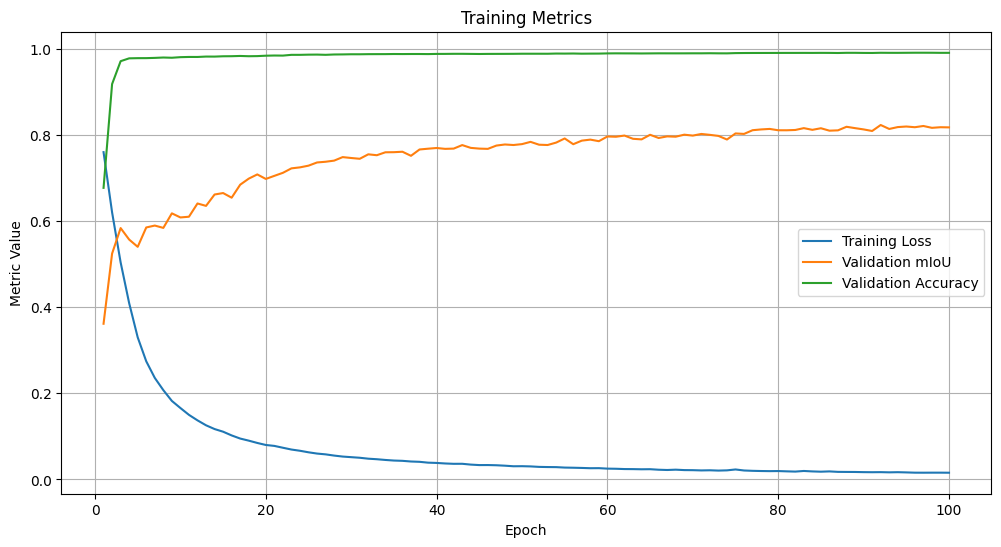

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, AdamW
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
num_classes = 2  # Two-class dataset
image_size = (512, 512)  # Resize images to 512x512
batch_size = 32
num_epochs = 100
learning_rate = 5e-5
checkpoint_path = "./best_model_checkpoint.pth"

# Paths
train_image_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/train/images"
train_mask_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/train/masks"
valid_image_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/valid/images"
valid_mask_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/valid/masks"
test_image_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/images"
test_mask_dir = "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/masks"

# Dataset class
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, feature_extractor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.feature_extractor = feature_extractor
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Process image and mask
        image = self.feature_extractor(image, return_tensors="pt")["pixel_values"].squeeze(0)
        mask = np.array(mask.resize(image_size, Image.NEAREST))
        mask = torch.tensor(mask, dtype=torch.long)

        return {"pixel_values": image, "labels": mask}

# Metrics
def compute_metrics(preds, labels, num_classes):
    preds = preds.flatten()
    labels = labels.flatten()
    intersection = torch.zeros(num_classes, dtype=torch.float32)
    union = torch.zeros(num_classes, dtype=torch.float32)
    for cls in range(num_classes):
        intersection[cls] = ((preds == cls) & (labels == cls)).sum()
        union[cls] = ((preds == cls) | (labels == cls)).sum()

    miou = (intersection / (union + 1e-6)).mean().item()
    pixel_acc = (preds == labels).float().mean().item()
    return miou, pixel_acc

# Load datasets
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name, reduce_labels=False)

train_dataset = SegmentationDataset(train_image_dir, train_mask_dir, feature_extractor)
valid_dataset = SegmentationDataset(valid_image_dir, valid_mask_dir, feature_extractor)
test_dataset = SegmentationDataset(test_image_dir, test_mask_dir, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Load model
model = SegformerForSemanticSegmentation.from_pretrained(model_name, ignore_mismatched_sizes=True, num_labels=num_classes)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Metrics storage
train_losses = []
val_mious = []
val_accuracies = []
best_miou = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Training step
    for batch in train_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Validation step
    model.eval()
    total_miou = 0
    total_accuracy = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=inputs)
            logits = outputs.logits  # (batch_size, num_classes, height, width)

            # Resize logits to match the labels' size
            logits_upsampled = F.interpolate(logits, size=labels.shape[1:], mode="bilinear", align_corners=False)
            preds = torch.argmax(logits_upsampled, dim=1)

            # Compute metrics
            miou, accuracy = compute_metrics(preds.cpu(), labels.cpu(), num_classes)
            total_miou += miou
            total_accuracy += accuracy

    avg_miou = total_miou / len(valid_loader)
    avg_accuracy = total_accuracy / len(valid_loader)
    val_mious.append(avg_miou)
    val_accuracies.append(avg_accuracy)
    print(f"Validation mIoU: {avg_miou:.4f}, Pixel Accuracy: {avg_accuracy:.4f}")

    # Save best model
    if avg_miou > best_miou:
        best_miou = avg_miou
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved with mIoU: {best_miou:.4f}")

# Save metrics and plot
metrics_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs + 1)),
    "Training Loss": train_losses,
    "Validation mIoU": val_mious,
    "Validation Accuracy": val_accuracies
})
metrics_df.to_csv("training_metrics.csv", index=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(metrics_df["Epoch"], metrics_df["Training Loss"], label="Training Loss")
plt.plot(metrics_df["Epoch"], metrics_df["Validation mIoU"], label="Validation mIoU")
plt.plot(metrics_df["Epoch"], metrics_df["Validation Accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training Metrics")
plt.legend()
plt.grid()
plt.savefig("training_metrics_plot.png")
plt.show()


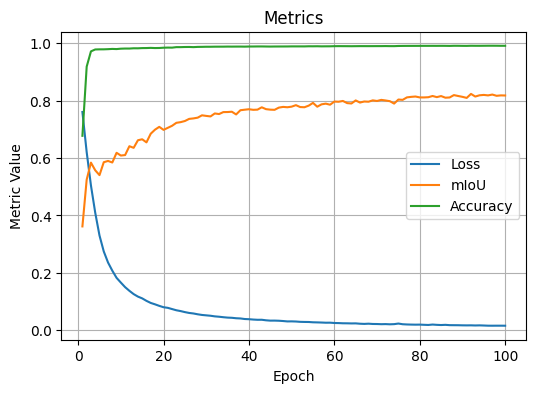

In [28]:
# Save metrics and plot
metrics_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs + 1)),
    "Training Loss": train_losses,
    "Validation mIoU": val_mious,
    "Validation Accuracy": val_accuracies
})
metrics_df.to_csv("training_metrics.csv", index=False)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(metrics_df["Epoch"], metrics_df["Training Loss"], label="Loss")
plt.plot(metrics_df["Epoch"], metrics_df["Validation mIoU"], label="mIoU")
plt.plot(metrics_df["Epoch"], metrics_df["Validation Accuracy"], label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Metrics")
plt.legend()
plt.grid()
plt.savefig("training_metrics_plot2.png")
plt.show()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_6823/2491777248.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defau

Saved visualization to: output_visualizations/visualization_0.png


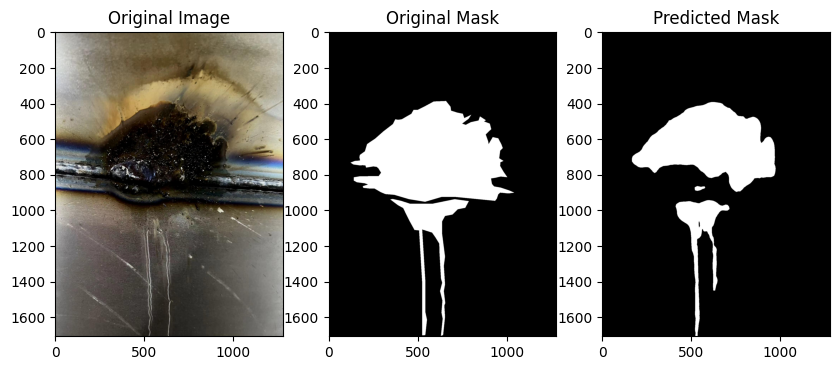

Saved visualization to: output_visualizations/visualization_1.png


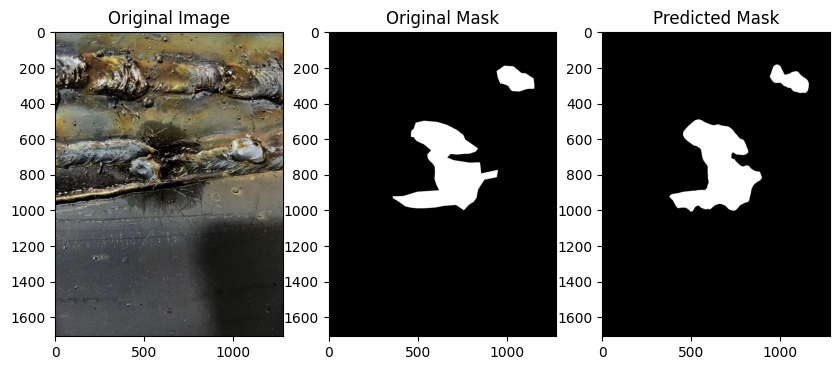

Saved visualization to: output_visualizations/visualization_2.png


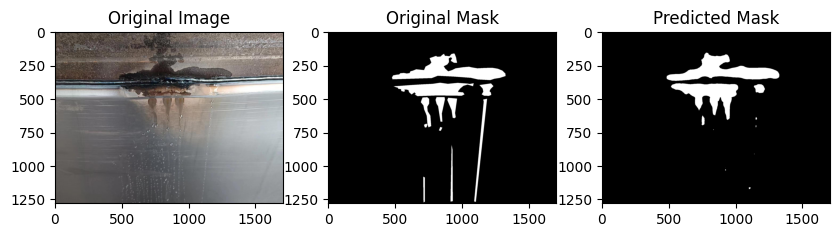

In [42]:


# Testing and visualization
def visualize_predictions(model, feature_extractor, images, masks, device,save_dir="output_visualizations"):
    model.eval()
    for idx, (img_path, mask_path) in enumerate(zip(images, masks)):
        image = Image.open(img_path).convert("RGB")
        original_mask = Image.open(mask_path)
        input_image = feature_extractor(image, return_tensors="pt")['pixel_values'].to(device)

        with torch.no_grad():
            outputs = model(pixel_values=input_image)

        logits = outputs.logits
        logits_upsampled = F.interpolate(
            logits,
            size=original_mask.size[::-1],  # (width, height) in PIL format
            mode="bilinear",
            align_corners=False,
        )
        predicted_mask = torch.argmax(logits_upsampled, dim=1).squeeze(0).cpu().numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("Original Mask")
        plt.imshow(np.array(original_mask), cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predicted_mask, cmap="gray")

        # Save the figure
        output_path = os.path.join(save_dir, f"visualization_{idx}.png")
        plt.savefig(output_path)
        print(f"Saved visualization to: {output_path}")
        
        plt.show()
import matplotlib.pyplot as plt
# Example usage
sample_images = ["/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/images/379_JPG.rf.bbb24187e060950e3180abf864a3a19a.jpg",
                "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/images/359_JPG.rf.127a9632ee541e39340cdf3b1bc38a4b.jpg",
                 "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/images/338_JPG.rf.70b4d7b46bf929ce3fb28446a45a8953.jpg",
                "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/images/376_JPG.rf.7270034bfa4ad07c8f7dae4da8d71825.jpg"
                ]

sample_masks = ["/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/masks/379_JPG.rf.bbb24187e060950e3180abf864a3a19a_mask.png",
                "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/masks/359_JPG.rf.127a9632ee541e39340cdf3b1bc38a4b_mask.png",
                "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/masks/338_JPG.rf.70b4d7b46bf929ce3fb28446a45a8953_mask.png",
                "/mnt/c/Users/Owner/Downloads/----.v4i.png-mask-semantic/test/masks/376_JPG.rf.7270034bfa4ad07c8f7dae4da8d71825_mask.png"
               ]


# model = SegformerForSemanticSegmentation.from_pretrained("best_model_checkpoint.pth")
# model = torch.load("./best_model_entire.pth")
# Initialize the model with the same configuration
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name, ignore_mismatched_sizes=True, num_labels=num_classes
)

# Load the best model's weights from the checkpoint
model.load_state_dict(torch.load("models/best_model_checkpoint.pth"))

# Move the model to the device
model.to(device)

visualize_predictions(model, feature_extractor, sample_images, sample_masks, device)